In [1]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!pip3 install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.4 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.profilers import SimpleProfiler, AdvancedProfiler
import torch.nn.functional as F
from torch.functional import Tensor
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

import sys, os, math, time, json, random, gc, copy, itertools, shutil

# functions of Google Colab
from google.colab import files, drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# load kaggle access file
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!chmod 600 /content/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
start_time = time.time()
!kaggle datasets download "mothspaws/children-vs-adults"
!unzip "children-vs-adults.zip"
!rm "children-vs-adults.zip"
print("--- %s seconds ---" % (time.time() - start_time))

Dataset URL: https://www.kaggle.com/datasets/mothspaws/children-vs-adults
License(s): unknown
  0% 0.00/27.8M [00:00<?, ?B/s]
100% 27.8M/27.8M [00:00<00:00, 1.33GB/s]
Archive:  children-vs-adults.zip
  inflating: children_vs_adults/train/adults/100.jpg  
  inflating: children_vs_adults/train/adults/101.jpg  
  inflating: children_vs_adults/train/adults/102.jpg  
  inflating: children_vs_adults/train/adults/103.jpg  
  inflating: children_vs_adults/train/adults/104.jpg  
  inflating: children_vs_adults/train/adults/105.jpg  
  inflating: children_vs_adults/train/adults/106.jpg  
  inflating: children_vs_adults/train/adults/107.jpg  
  inflating: children_vs_adults/train/adults/108.jpg  
  inflating: children_vs_adults/train/adults/109.jpg  
  inflating: children_vs_adults/train/adults/110.jpg  
  inflating: children_vs_adults/train/adults/111.jpg  
  inflating: children_vs_adults/train/adults/112.jpg  
  inflating: children_vs_adults/train/adults/113.jpg  
  inflating: children_vs_adult

In [12]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# structure: /children-vs-adults/{train,valid}/{children,adults}/...
data_dir = "/content/children_vs_adults"

img_size = 224

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("Classes:", class_names)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Classes: ['adults', 'children']
Train: 680, Val: 120


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ResNet
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in resnet.parameters():
    param.requires_grad = False

# replace by clasificator to 2 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

model = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

Device: cuda


In [14]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Val", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


num_epochs = 8

best_val_acc = 0.0
best_state_dict = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}%")
    print(f"Val   loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

print(f"\nNejlepší validační accuracy: {best_val_acc*100:.2f}%")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)


Epoch 1/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6595, acc: 61.47%
Val   loss: 0.6248, acc: 65.00%

Epoch 2/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5417, acc: 77.21%
Val   loss: 0.5700, acc: 70.83%

Epoch 3/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4883, acc: 78.68%
Val   loss: 0.5382, acc: 70.83%

Epoch 4/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee9b7761ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee9b7761ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee9b7761ee0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ee9b7761ee0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Train loss: 0.4598, acc: 80.15%
Val   loss: 0.5186, acc: 75.00%

Epoch 5/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4300, acc: 81.76%
Val   loss: 0.5148, acc: 77.50%

Epoch 6/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4279, acc: 82.35%
Val   loss: 0.5062, acc: 79.17%

Epoch 7/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4033, acc: 83.68%
Val   loss: 0.5006, acc: 80.00%

Epoch 8/8


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4013, acc: 82.50%
Val   loss: 0.4999, acc: 78.33%

Nejlepší validační accuracy: 80.00%


In [8]:
save_path = "/content/drive/MyDrive/artificial/PVI_12/best_model_ResNet18.pt"
torch.save(model.state_dict(), save_path)
print("Saved:", save_path)

Saved: /content/drive/MyDrive/artificial/PVI_12/best_model_ResNet50.pt


tensor([[0.8842, 0.1158]], device='cuda:0')
tensor([[0.4470, 0.5530]], device='cuda:0')


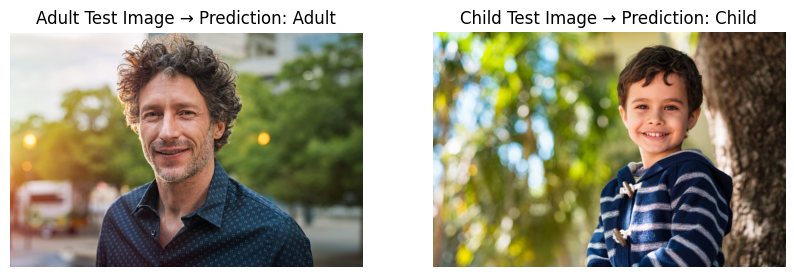

In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

MODEL_PATH = "/content/drive/MyDrive/artificial/PVI_12/best_model_ResNet18.pt"
ADULT_IMG_PATH = "/content/drive/MyDrive/artificial/PVI_12/test_adult.jpg"
CHILD_IMG_PATH = "/content/drive/MyDrive/artificial/PVI_12/test_child.jpg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = torch.load(MODEL_PATH, map_location=device)
# model.eval()

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class_names = ["Adult", "Child"]

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    print(torch.softmax(output, dim=1))
    return image, class_names[predicted_class]

adult_img, adult_pred = predict_image(ADULT_IMG_PATH)
child_img, child_pred = predict_image(CHILD_IMG_PATH)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(adult_img)
plt.title(f"Adult Test Image → Prediction: {adult_pred}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(child_img)
plt.title(f"Child Test Image → Prediction: {child_pred}")
plt.axis("off")

plt.show()